In [11]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import cv2

In [9]:
def crop_image(img_url):
    # Load image, grayscale, Gaussian blur, Otsu's threshold
    image = cv2.imread(img_url)
    original = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (25,25), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Perform morph operations, first open to remove noise, then close to combine
    noise_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, noise_kernel, iterations=2)
    close_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
    close = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, close_kernel, iterations=3)

    # Find enclosing boundingbox and crop ROI
    coords = cv2.findNonZero(close)
    x,y,w,h = cv2.boundingRect(coords)
    cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
    crop = original[y:y+h, x:x+w]
    cv2.imwrite(img_url, crop)

In [15]:
batch_size = 8
# img_height = 197
img_height = 49
img_width = 30
# img_width = 200

In [14]:
dir_20 = "dataset/both20-new"
dir_original = "dataset/both20"
all_digits = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

for digit in all_digits:
    for filename in os.listdir(dir_original + "/" + digit):
        crop_image(os.path.join(dir_original + "/" + digit, filename))
        img = Image.open(os.path.join(dir_original + "/" + digit, filename))
        img = img.resize((30, 49), Image.ANTIALIAS)
        img.save(os.path.join(dir_20 + "/" + digit, filename))

/var/folders/15/bmbcw71s1l12pc4g0617fwww0000gn/T/ipykernel_48239/640277397.py:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((30, 49), Image.ANTIALIAS)


In [16]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "dataset/both20-new",
  validation_split=0.2,
  subset="training",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1000 files belonging to 10 classes.
Using 800 files for training.
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-06-29 16:17:28.284267: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-29 16:17:28.284641: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "dataset/both20-new",
  validation_split=0.2,
  subset="validation",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1000 files belonging to 10 classes.
Using 200 files for validation.


In [18]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 49, 30, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 49, 30, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 15, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 15, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 7, 32)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 7, 64)         1

In [23]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2023-06-29 16:17:51.414513: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-29 16:17:51.415142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 4s 14ms/step - loss: 0.5421 - accuracy: 0.8462 - val_loss: 2.5254e-04 - val_accuracy: 1.0000


2023-06-29 16:17:55.130029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 2/10
100/100 [==============================] - 2s 17ms/step - loss: 1.3769e-04 - accuracy: 1.0000 - val_loss: 1.1148e-04 - val_accuracy: 1.0000
Epoch 3/10
100/100 [==============================] - 1s 12ms/step - loss: 7.0618e-05 - accuracy: 1.0000 - val_loss: 5.7464e-05 - val_accuracy: 1.0000
Epoch 4/10
100/100 [==============================] - 1s 13ms/step - loss: 4.2300e-05 - accuracy: 1.0000 - val_loss: 4.0842e-05 - val_accuracy: 1.0000
Epoch 5/10
100/100 [==============================] - 1s 12ms/step - loss: 2.9612e-05 - accuracy: 1.0000 - val_loss: 2.6768e-05 - val_accuracy: 1.0000
Epoch 6/10
100/100 [==============================] - 1s 11ms/step - loss: 2.1359e-05 - accuracy: 1.0000 - val_loss: 1.9763e-05 - val_accuracy: 1.0000
Epoch 7/10
100/100 [==============================] - 1s 11ms/step - loss: 1.6133e-05 - accuracy: 1.0000 - val_loss: 1.5122e-05 - val_accuracy: 1.0000
Epoch 8/10
100/100 [==============================] - 1s 11ms/step - loss: 1.2591e-05 - accura

In [30]:
print(model.evaluate(val_ds)[1])

25/25 [==============================] - 0s 9ms/step - loss: 7.7792e-06 - accuracy: 1.0000
1.0


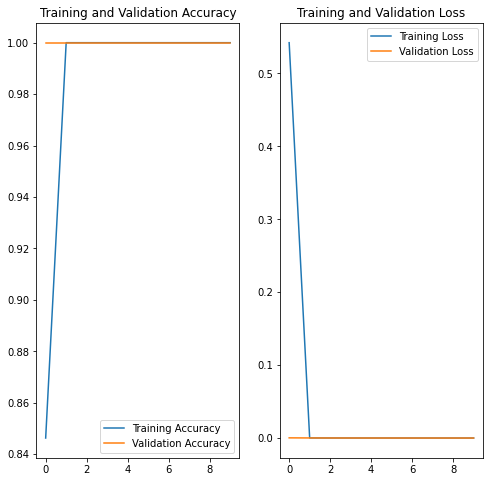

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
def recognize_image(path):
    img = tf.keras.utils.load_img(
        path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

In [27]:
recognize_image("dataset/both20-new/0/1zero.jpg")
recognize_image("dataset/both20-new/0/2zero.jpg")
recognize_image("dataset/both20-new/0/3zero.jpg")
recognize_image("dataset/both20-new/0/4zero.jpg")
recognize_image("dataset/both20-new/0/5zero.jpg")
recognize_image("dataset/both20-new/1/28one.jpg")
recognize_image("dataset/both20-new/0/30zero.jpg")
recognize_image("dataset/both20-new/3/9three.jpg")

This image most likely belongs to 0 with a 100.00 percent confidence.
This image most likely belongs to 0 with a 100.00 percent confidence.
This image most likely belongs to 0 with a 100.00 percent confidence.
This image most likely belongs to 0 with a 100.00 percent confidence.
This image most likely belongs to 0 with a 100.00 percent confidence.
This image most likely belongs to 1 with a 100.00 percent confidence.
This image most likely belongs to 0 with a 100.00 percent confidence.
This image most likely belongs to 3 with a 100.00 percent confidence.


In [28]:
# save model to file
model.save("model-small-pics.h5")